# Train lstm2 model for phishing URL detection

## Imports

In [2]:
import numpy as np
import os
import pathlib

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Sequential

import tensorflow_text as tf_text

In [3]:
dataset_dir = pathlib.Path("../URL_dataset/")
model_dir = pathlib.Path('../URL_models/')
checkpoint_dir = pathlib.Path('../URL_checkpoints/')

In [4]:
import datetime
date = datetime.datetime.now()
date = '_'.join(str(date).split()).replace(':', ';')
print(date)

2021-09-07_22;02;50.725602


In [5]:
os.listdir(dataset_dir)

['benign', 'phishing']

## Params

In [6]:
model_name = "lstm2"
batch_size = 32
rest_split_ratio = 0.2
test_split_ratio = 0.2

unicode_max = 1114111

## Load dataset

In [7]:
train_ds = keras.preprocessing.text_dataset_from_directory(
  dataset_dir,
  validation_split=rest_split_ratio,
  subset="training",
  label_mode = 'binary',
  seed=132,
  batch_size=batch_size)

Found 45343 files belonging to 2 classes.
Using 36275 files for training.


In [8]:
rest_ds = keras.preprocessing.text_dataset_from_directory(
  dataset_dir,
  validation_split=rest_split_ratio,
  subset="validation",
  label_mode='binary',
  seed=132,
  batch_size=batch_size)

Found 45343 files belonging to 2 classes.
Using 9068 files for validation.


In [9]:
rest_batches = rest_ds.cardinality().numpy()
print(rest_batches)

284


In [10]:
val_ds = rest_ds.skip(int(rest_batches * test_split_ratio // batch_size))
test_ds = rest_ds.take(int(rest_batches * test_split_ratio // batch_size))

In [11]:
class_names = train_ds.class_names

In [12]:
class_names

['benign', 'phishing']

## Explore dataset

In [13]:
b = train_ds.take(1)

In [14]:
b

<TakeDataset shapes: ((None,), (None, 1)), types: (tf.string, tf.float32)>

In [26]:
for batch in b:
    for url, label in zip(batch[0].numpy(), batch[1].numpy()):
        print(url, class_names[int(label[0])])

b'http://motthegioi.vn/cau-vong-luc-sac/chia-se-tam-su/nhung-cau-chuyen-cong-khai-truyen-lua-cho-ca-the-he-187080.html' benign
b'http://distractify.com/post/related/id/554cea434a0c4b1c2e4f885a/skip/40/limit/10/back/0' benign
b'http://www.zbjlqm.com/diy/?us.battle.net/login/en/?ref=http://us.battle.net/d3/en/index&amp;app=com-d3' phishing
b'http://pastehtml.com/view/bal84jjwu.html' phishing
b'http://indianexpress.com/article/india/india-others/if-they-israel-are-your-friend-do-not-let-them-choose-your-enemies-gholamreza-ansari/' benign
b'http://plarium.com/es/juegos-de-estrategia/stormfall-age-of-war/noticias/confusion-y-discordia/' benign
b'http://www.midea-0512.com/js/?http://us.battle.net/login/en/?ref=http://vcacoqlus.battle.net/d3/en/index&amp;app=com-d3' phishing
b'https://tsite.jp/login/index.pl?xpg=PCUI0401&ret=https%3a%2f%2ftsite%2ejp%2fentry%2findex%2epl%3fxpg%3dPCEC0102%26pid%3d00026' benign
b'http://plarium.com/en/strategy-games/sparta-war-of-empires/news/besiege-other-playe

## Vectorize

Cannot use the vectorization layers since it is not supported in TFJS; we can rather have a custom tokenizer which can be then exported as json then loaded in JS

In [27]:
tokenizer = tf_text.UnicodeCharTokenizer()

In [28]:
train_ds = train_ds.map(lambda x, y: (tokenizer.tokenize(x), y))
val_ds = val_ds.map(lambda x, y: (tokenizer.tokenize(x), y))
test_ds = test_ds.map(lambda x, y: (tokenizer.tokenize(x), y))

## Tune dataset

In [29]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(256).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Model

In [42]:
num_classes = 2
embedding_dim = 16
lstm1_units = 256
lstm2_units = 512
dropout_prob1 = 0.2
dropout_prob2 = 0.3
reg_rate1 = 0.005
reg_rate2 = 0.001

model = Sequential([
    layers.Embedding(unicode_max, embedding_dim),
    layers.LSTM(
        lstm1_units,
        kernel_regularizer=regularizers.l2(reg_rate1),
        recurrent_regularizer=regularizers.l2(reg_rate1),
        bias_regularizer=regularizers.l2(reg_rate1),
#         activity_regularizer=regularizers.l2(reg_rate1,
        dropout=dropout_prob1,
        return_sequences=True
    ),
    layers.LSTM(
        lstm2_units,
        kernel_regularizer=regularizers.l2(reg_rate1),
        recurrent_regularizer=regularizers.l2(reg_rate1),
        bias_regularizer=regularizers.l2(reg_rate1),
#         activity_regularizer=regularizers.l2(reg_rate1,
        dropout=dropout_prob2,
    ),
#     layers.Dense(256, activation='relu',
# #               activity_regularizer=regularizers.l2(reg_rate2)
#               ),
    layers.Dense(num_classes-1)
])

In [43]:
model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 16)          17825776  
_________________________________________________________________
lstm_6 (LSTM)                (None, None, 256)         279552    
_________________________________________________________________
lstm_7 (LSTM)                (None, 512)               1574912   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 513       
Total params: 19,680,753
Trainable params: 19,680,753
Non-trainable params: 0
_________________________________________________________________


In [44]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


## Training

In [45]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        # The saved model name will include the current epoch.
        filepath=checkpoint_dir / f"{date}_{model_name}_valacc{{val_accuracy:.4f}}_e{{epoch}}",
        save_best_only=True,  # Only save a model if `val_loss` has improved.
        monitor="val_loss",
        verbose=1,
    ),
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-4,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=4,
        verbose=1,
    )
]


In [46]:
epochs=15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=callbacks
)

Epoch 1/15


C:\Users\fracta\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\framework\indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_3/lstm_6/RaggedToTensor/boolean_mask_1/GatherV2:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_3/lstm_6/RaggedToTensor/boolean_mask/GatherV2:0", shape=(None, 16), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_3/lstm_6/RaggedToTensor/Shape:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


1134/1134 [==============================] - 3549s 3s/step - loss: 1.6962 - accuracy: 0.9386 - val_loss: 0.3839 - val_accuracy: 0.9395

Epoch 00001: val_loss improved from inf to 0.38388, saving model to ..\URL_checkpoints\2021-09-07_22;02;50.725602_lstm2_valacc0.9395_e1


INFO:tensorflow:Assets written to: ..\URL_checkpoints\2021-09-07_22;02;50.725602_lstm2_valacc0.9395_e1\assets


INFO:tensorflow:Assets written to: ..\URL_checkpoints\2021-09-07_22;02;50.725602_lstm2_valacc0.9395_e1\assets


Epoch 2/15
1134/1134 [==============================] - 3532s 3s/step - loss: 0.2184 - accuracy: 0.9618 - val_loss: 0.2061 - val_accuracy: 0.9553

Epoch 00002: val_loss improved from 0.38388 to 0.20611, saving model to ..\URL_checkpoints\2021-09-07_22;02;50.725602_lstm2_valacc0.9553_e2


INFO:tensorflow:Assets written to: ..\URL_checkpoints\2021-09-07_22;02;50.725602_lstm2_valacc0.9553_e2\assets


INFO:tensorflow:Assets written to: ..\URL_checkpoints\2021-09-07_22;02;50.725602_lstm2_valacc0.9553_e2\assets


Epoch 3/15
1134/1134 [==============================] - 3511s 3s/step - loss: 0.1613 - accuracy: 0.9644 - val_loss: 0.1664 - val_accuracy: 0.9688

Epoch 00003: val_loss improved from 0.20611 to 0.16640, saving model to ..\URL_checkpoints\2021-09-07_22;02;50.725602_lstm2_valacc0.9688_e3


INFO:tensorflow:Assets written to: ..\URL_checkpoints\2021-09-07_22;02;50.725602_lstm2_valacc0.9688_e3\assets


INFO:tensorflow:Assets written to: ..\URL_checkpoints\2021-09-07_22;02;50.725602_lstm2_valacc0.9688_e3\assets


Epoch 4/15
1134/1134 [==============================] - 3522s 3s/step - loss: 0.1689 - accuracy: 0.9622 - val_loss: 0.1410 - val_accuracy: 0.9645

Epoch 00004: val_loss improved from 0.16640 to 0.14103, saving model to ..\URL_checkpoints\2021-09-07_22;02;50.725602_lstm2_valacc0.9645_e4


INFO:tensorflow:Assets written to: ..\URL_checkpoints\2021-09-07_22;02;50.725602_lstm2_valacc0.9645_e4\assets


INFO:tensorflow:Assets written to: ..\URL_checkpoints\2021-09-07_22;02;50.725602_lstm2_valacc0.9645_e4\assets


Epoch 5/15
1134/1134 [==============================] - 3522s 3s/step - loss: 0.1469 - accuracy: 0.9653 - val_loss: 0.5058 - val_accuracy: 0.8258

Epoch 00005: val_loss did not improve from 0.14103
Epoch 6/15
1134/1134 [==============================] - 3516s 3s/step - loss: 0.1809 - accuracy: 0.9658 - val_loss: 0.1242 - val_accuracy: 0.9721

Epoch 00006: val_loss improved from 0.14103 to 0.12420, saving model to ..\URL_checkpoints\2021-09-07_22;02;50.725602_lstm2_valacc0.9721_e6


INFO:tensorflow:Assets written to: ..\URL_checkpoints\2021-09-07_22;02;50.725602_lstm2_valacc0.9721_e6\assets


INFO:tensorflow:Assets written to: ..\URL_checkpoints\2021-09-07_22;02;50.725602_lstm2_valacc0.9721_e6\assets


Epoch 7/15
1134/1134 [==============================] - 3521s 3s/step - loss: 0.1411 - accuracy: 0.9658 - val_loss: 0.1217 - val_accuracy: 0.9726

Epoch 00007: val_loss improved from 0.12420 to 0.12174, saving model to ..\URL_checkpoints\2021-09-07_22;02;50.725602_lstm2_valacc0.9726_e7


INFO:tensorflow:Assets written to: ..\URL_checkpoints\2021-09-07_22;02;50.725602_lstm2_valacc0.9726_e7\assets


INFO:tensorflow:Assets written to: ..\URL_checkpoints\2021-09-07_22;02;50.725602_lstm2_valacc0.9726_e7\assets


Epoch 8/15
1134/1134 [==============================] - 3527s 3s/step - loss: 0.1439 - accuracy: 0.9667 - val_loss: 0.1339 - val_accuracy: 0.9692

Epoch 00008: val_loss did not improve from 0.12174
Epoch 9/15
1134/1134 [==============================] - 3522s 3s/step - loss: 0.1323 - accuracy: 0.9673 - val_loss: 0.1167 - val_accuracy: 0.9734

Epoch 00009: val_loss improved from 0.12174 to 0.11673, saving model to ..\URL_checkpoints\2021-09-07_22;02;50.725602_lstm2_valacc0.9734_e9


INFO:tensorflow:Assets written to: ..\URL_checkpoints\2021-09-07_22;02;50.725602_lstm2_valacc0.9734_e9\assets


INFO:tensorflow:Assets written to: ..\URL_checkpoints\2021-09-07_22;02;50.725602_lstm2_valacc0.9734_e9\assets


Epoch 10/15
1134/1134 [==============================] - 3529s 3s/step - loss: 0.1367 - accuracy: 0.9674 - val_loss: 0.1196 - val_accuracy: 0.9738

Epoch 00010: val_loss did not improve from 0.11673
Epoch 11/15
1134/1134 [==============================] - 3526s 3s/step - loss: 0.1300 - accuracy: 0.9676 - val_loss: 0.1312 - val_accuracy: 0.9620

Epoch 00011: val_loss did not improve from 0.11673
Epoch 12/15
1134/1134 [==============================] - 3517s 3s/step - loss: 0.1557 - accuracy: 0.9617 - val_loss: 0.1186 - val_accuracy: 0.9726

Epoch 00012: val_loss did not improve from 0.11673
Epoch 13/15
1134/1134 [==============================] - 3519s 3s/step - loss: 0.1281 - accuracy: 0.9683 - val_loss: 0.1417 - val_accuracy: 0.9638

Epoch 00013: val_loss did not improve from 0.11673
Epoch 00013: early stopping


## Save model

In [47]:
val_acc = history.history['val_accuracy']
model.save(model_dir / f"{date}_{model_name}_valacc{val_acc[-1]:0.4f}_e{len(val_acc)}_b{batch_size}.tf",
           include_optimizer=True)

INFO:tensorflow:Assets written to: ..\URL_models\2021-09-07_22;02;50.725602_lstm2_valacc0.9638_e13_b32.tf\assets


INFO:tensorflow:Assets written to: ..\URL_models\2021-09-07_22;02;50.725602_lstm2_valacc0.9638_e13_b32.tf\assets


## Load model

In [53]:
# change filename to the model you want to load
model_filename = "2021-09-07_22;02;50.725602_lstm2_valacc0.9734_e9"
model2 = keras.models.load_model(
    checkpoint_dir / model_filename,
    compile=True)

## Visulaize loss and acc

In [48]:
history.history

{'loss': [1.696229338645935,
  0.21840135753154755,
  0.16129134595394135,
  0.16886678338050842,
  0.14692680537700653,
  0.18088044226169586,
  0.1411307454109192,
  0.14391213655471802,
  0.1323399394750595,
  0.13669273257255554,
  0.13001056015491486,
  0.15565335750579834,
  0.12805648148059845],
 'accuracy': [0.9385802745819092,
  0.9617642760276794,
  0.9644107222557068,
  0.9622053503990173,
  0.9652653336524963,
  0.9657615423202515,
  0.9657615423202515,
  0.9666712880134583,
  0.9672501683235168,
  0.9674431681632996,
  0.9676085710525513,
  0.9617091417312622,
  0.9683253169059753],
 'val_loss': [0.3838765621185303,
  0.20610937476158142,
  0.16640418767929077,
  0.1410321593284607,
  0.5057688355445862,
  0.12419702112674713,
  0.1217416301369667,
  0.13391311466693878,
  0.11673220992088318,
  0.11961584538221359,
  0.13120444118976593,
  0.11858268827199936,
  0.1417120397090912],
 'val_accuracy': [0.9394643902778625,
  0.9552899599075317,
  0.9687914848327637,
  0.9644

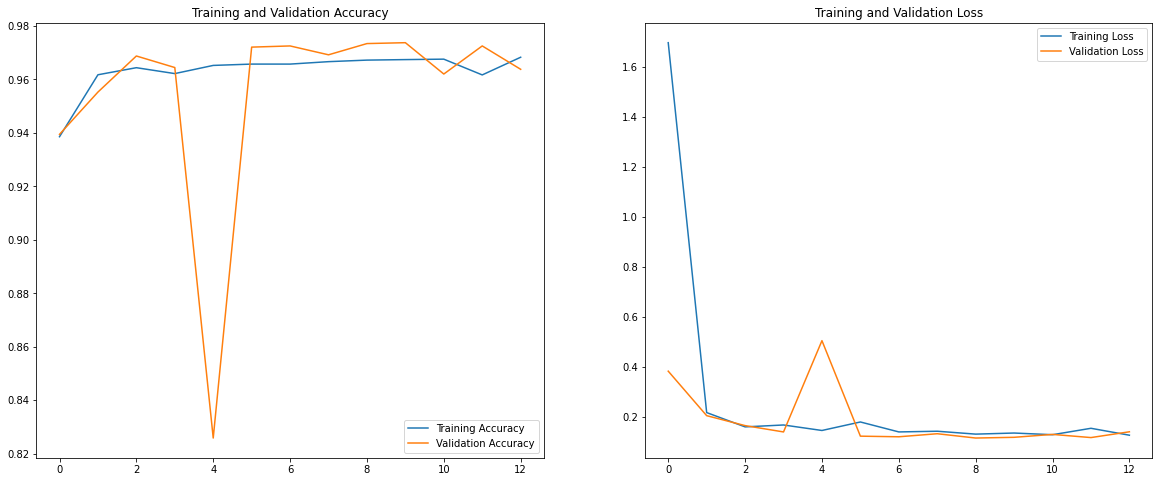

In [49]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# epochs_range = range(epochs)
epochs_range = history.epoch

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


## Evaluate (test)

In [50]:
val_results = model.evaluate(val_ds, batch_size=256)
print("val loss, val acc:", val_results)

283/283 [==============================] - 75s 263ms/step - loss: 0.1417 - accuracy: 0.9638
val loss, val acc: [0.1417120397090912, 0.9638113975524902]


In [54]:
val_results = model2.evaluate(val_ds, batch_size=256)
print("val loss, val acc:", val_results)

283/283 [==============================] - 78s 272ms/step - loss: 0.1167 - accuracy: 0.9734
val loss, val acc: [0.11673220992088318, 0.9734395742416382]


In [51]:
results = model.evaluate(test_ds, batch_size=32)
print("test loss, test acc:", results)


1/1 [==============================] - 1s 502ms/step - loss: 0.1079 - accuracy: 0.9375
test loss, test acc: [0.10788491368293762, 0.9375]


In [55]:
results = model2.evaluate(test_ds, batch_size=32)
print("test loss, test acc:", results)


1/1 [==============================] - 0s 259ms/step - loss: 0.0769 - accuracy: 0.9688
test loss, test acc: [0.07691548764705658, 0.96875]


In [52]:
test_ds.cardinality().numpy()

1